# Finetuning a Cross-Encoder on STS

In this notebook, we will finetune a Cross-Encoder on Semantic Textual Similarity text.

First let's look at the architecture of a cross encoder.

In a Bi-Encoder, we pass both the sentences(A and B) separately to the finetuned model and use the pooled embeddings to compare the similarity between the sentences (cosine or dot product).

In a Cross-Encoder, we pass both the sentences together in the model and finetune the model with a linear head with output size 1, paired with a Binary Cross Entropy loss.

In case of BERT, this would look something like this -


| ![](assets/cross_encoder.png) | 
|:--:| 
| Fig. 1. Illustration of a Cross-Encoder architecture. |
<br>

Cross-Encoders perform better than Bi-Encoders, results are detailed in the original [Sentence-BERT paper](https://arxiv.org/abs/1908.10084). However, they are not practical for most of the applications as we can't use them to pre-compute and index our context/document embeddings.

> Cross-Encoders can be used whenever you have a pre-defined set of sentence pairs you want to score. For example, you have 100 sentence pairs and you want to get similarity scores for these 100 pairs.
>
> Bi-Encoders are used whenever you need a sentence embedding in a vector space for efficient comparison. Applications are for example Information Retrieval / Semantic Search or Clustering. Cross-Encoders would be the wrong choice for these application: Clustering 10,000 sentence with CrossEncoders would require computing similarity scores for about 50 Million sentence combinations, which takes about 65 hours. With a Bi-Encoder, you compute the embedding for each sentence, which takes only 5 seconds. You can then perform the clustering.
>
> Source: https://www.sbert.net/examples/applications/cross-encoder/README.html

Cross-Encoders are trypically used as a Re-Ranker.


| ![](assets/cross_encoder_reranker.png) | 
|:--:| 
| Fig. 2. Illustration of a Cross-Encoder as a Re-Ranker. (Image source: https://www.sbert.net/examples/applications/retrieve_rerank/README.html) |
<br>

This is the most common setup for semantic search. We pass our `Document collection` though a Bi-Encoder finetuned for STS tasks and index the embeddings in a vector database.

During query time, we embed the query using the same Bi-Enocoder and fetch top k candidates from our database. This is the Retrieval part.

Next, we can further refine the results by passing the top k(query, retrieved) document pairs through a Cross-Encoder finetuned for STS tasks. Cross-Enocder essentially re-sorts the retrieved candidate documents such that the top most relevant document has the highest score.

In [1]:
import random
from typing import Callable, Iterable

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import BertTokenizerFast, BertModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

In [43]:
# example of next sentence prediction objective used for a cross encoder
tokenized_texts = tokenizer(["I am hungry."], ["Order some food for me"], padding=True, truncation=True)
tokenizer.decode(tokenized_texts["input_ids"][0])

'[CLS] i am hungry. [SEP] order some food for me [SEP]'

## Data preparation

In [3]:
dataset = datasets.load_dataset("glue", "stsb", split="train")
len(dataset), dataset[0]

Reusing dataset glue (/home/utsav/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


(5749,
 {'sentence1': 'A plane is taking off.',
  'sentence2': 'An air plane is taking off.',
  'label': 5.0,
  'idx': 0})

Next we look at the distribution of lenghts(from a sample) of sentence1 and sentence2 to choose the max_length we want to restrict our tokenizer to.

In [4]:
text_lengths1, text_lengths2 = [], []
for data in tqdm(dataset):
    if random.random() > 0.5:
        text_lengths1.append(len(data["sentence1"]))
        text_lengths2.append(len(data["sentence2"]))

100%|██████████████████████████████████████████████████████████████████| 5749/5749 [00:00<00:00, 23152.97it/s]


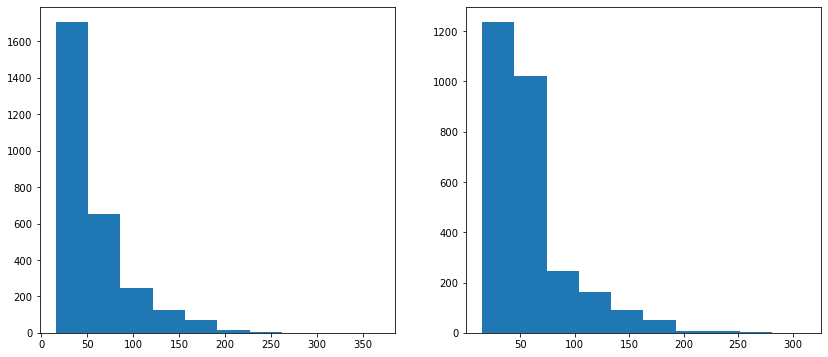

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].hist(text_lengths1)
ax[1].hist(text_lengths2);

In [6]:
%%time

MAX_LENGTH = 128

tokenized_texts = tokenizer([data["sentence1"] for data in dataset],
                            [data["sentence2"] for data in dataset],
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

CPU times: user 1.15 s, sys: 353 ms, total: 1.5 s
Wall time: 743 ms


In [7]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Now we will create out custom dataset and dataloaders with train/validation split for training.

In [8]:
class StsDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {"input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
                "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
                "token_type_ids": torch.tensor(self.tokens["token_type_ids"][ix], dtype=torch.long),
                "label": torch.tensor(self.labels[ix] / 5.0, dtype=torch.float)}

    def __len__(self) -> len:
        return len(self.tokens["input_ids"])

In [9]:
%%time

sts_dataset = StsDataset(tokenized_texts, [data["label"] for data in dataset])

CPU times: user 246 ms, sys: 5.14 ms, total: 251 ms
Wall time: 235 ms


In [10]:
train_ratio = 0.8
n_total = len(sts_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(sts_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
len(train_dataloader), len(val_dataloader)

(288, 72)

In [12]:
next(iter(train_dataloader))

{'input_ids': tensor([[  101,  2117, 10563,  ...,     0,     0,     0],
         [  101,  2149,  2398,  ...,     0,     0,     0],
         [  101,  1045,  1005,  ...,     0,     0,     0],
         ...,
         [  101,  1020,  1012,  ...,     0,     0,     0],
         [  101,  3059,  3539,  ...,     0,     0,     0],
         [  101,  8845, 16889,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'label': tensor([0.2800, 0.9600, 1.0000, 0.9200, 0.2000, 0.9600, 0.3200, 0.4400, 0.4800,
         0.8000, 0.6400, 0.5600, 0.8500

## Model config

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)


    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        token_type_ids = data["token_type_ids"].to(device)
        return self.linear(
            self.bert_model(input_ids, attention_mask, token_type_ids).pooler_output
        ).view(-1)

In [15]:
model = CrossEncoderBert()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.BCEWithLogitsLoss()

In [17]:
model = model.to(device)

## Training loop

In [18]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def train_step_fn(x: torch.tensor, target: torch.tensor) -> float:
        model.train()
        logits = model(x)
        loss = loss_fn(logits, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def val_step_fn(x: torch.tensor, target: torch.tensor) -> float:
        model.eval()
        logits = model(x)
        loss = loss_fn(logits, target)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader,
    step_fn: Callable[[torch.tensor, torch.tensor], float],
    is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["label"].to(device))
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [19]:
%%time

n_epochs = 4

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Epoch 1

Training ...
step     0/288, loss =  0.725
step    64/288, loss =  0.608
step   128/288, loss =  0.626
step   192/288, loss =  0.551
step   256/288, loss =  0.547

Validating ...
step     0/72, loss =  0.580
step    64/72, loss =  0.568

Epoch 2

Training ...
step     0/288, loss =  0.621
step    64/288, loss =  0.573
step   128/288, loss =  0.569
step   192/288, loss =  0.671
step   256/288, loss =  0.543

Validating ...
step     0/72, loss =  0.580
step    64/72, loss =  0.568

Epoch 3

Training ...
step     0/288, loss =  0.549
step    64/288, loss =  0.519
step   128/288, loss =  0.580
step   192/288, loss =  0.557
step   256/288, loss =  0.648

Validating ...
step     0/72, loss =  0.580
step    64/72, loss =  0.568

Epoch 4

Training ...
step     0/288, loss =  0.571
step    64/288, loss =  0.563
step   128/288, loss =  0.543
step   192/288, loss =  0.620
step   256/288, loss =  0.478

Validating ...
step     0/72, loss =  0.580
step    64/72, loss =  0.568
CPU times: u

In [20]:
train_losses, val_losses

([0.6042224639612768,
  0.5663815911652313,
  0.5663390109936396,
  0.5664176436968975],
 [0.5507968138489459,
  0.5507968138489459,
  0.5507968138489459,
  0.5507968138489459])

** Validation loss staying the same indicates that something is off. Please let me know if someone finds the issue.

Normally we look at losses over multiple epochs, but here we have only 4 epochs. One way to look at the mini batch losses is to use a running mean(smoothing) to reduce noise from per batch loss.

In [21]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

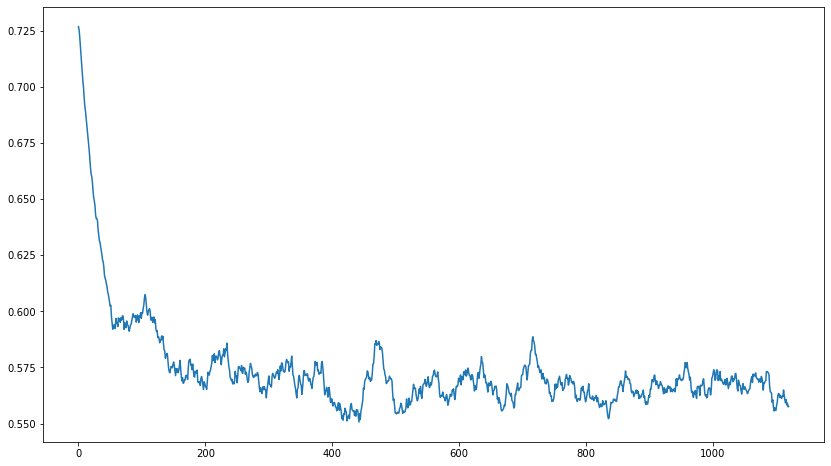

In [22]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

## Evaluation

Let's look at how this finetuned Cross-Encoder can be used to rank a collection of documents for a query.
We will look at few examples to manually inspect our finetuned model and the base-bert model.

In [96]:
def get_ranked_docs(
    tokenizer: BertTokenizerFast, finetuned_ce: CrossEncoderBert,
    base_bert: BertModel, query: str, corpus: list[str]
) -> None:
    
    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries, corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    )
    ce_scores = torch.nn.Sigmoid()(model.linear(model.bert_model(**tokenized_texts.to(device)).pooler_output))
    bert_scores = torch.nn.Sigmoid()(model.linear(bert_model(**tokenized_texts.to(device)).pooler_output))
    
    print(f"Query - {query} [Finetuned Cross-Encoder]\n---")
    scores = ce_scores.view(-1).cpu().detach().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")
    
    print(f"\nQuery - {query} [Bert Base]\n---")
    scores = bert_scores.view(-1).cpu().detach().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [97]:
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey."
]

query = "A man is eating pasta."

In [98]:
get_ranked_docs(tokenizer, model, bert_model, query, corpus)

Query - A man is eating pasta. [Finetuned Cross-Encoder]
---
0.74	A man is eating food.
0.41	A man is eating a piece of bread.
0.15	The girl is carrying a baby.
0.14	Two men pushed carts through the woods.
0.13	A man is riding a horse.
0.12	A woman is playing violin.
0.12	A man is riding a white horse on an enclosed ground.
0.12	A monkey is playing drums.
0.11	A cheetah is running behind its prey.

Query - A man is eating pasta. [Bert Base]
---
0.51	Two men pushed carts through the woods.
0.37	A man is eating food.
0.37	A man is eating a piece of bread.
0.37	A man is riding a horse.
0.36	A woman is playing violin.
0.36	A man is riding a white horse on an enclosed ground.
0.36	The girl is carrying a baby.
0.36	A monkey is playing drums.
0.36	A cheetah is running behind its prey.


In [104]:
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A woman is practicing jumps with her horse.",
    "A horse is running around the track."
]

query = "Horse jumped over the obstacle."

In [105]:
get_ranked_docs(tokenizer, model, bert_model, query, corpus)

Query - Horse jumped over the obstacle. [Finetuned Cross-Encoder]
---
0.62	A woman is practicing jumps with her horse.
0.57	A horse is running around the track.
0.27	A woman is playing violin.
0.19	Two men pushed carts through the woods.
0.18	A man is eating a piece of bread.
0.14	A man is eating food.

Query - Horse jumped over the obstacle. [Bert Base]
---
0.54	A man is eating a piece of bread.
0.54	A woman is playing violin.
0.48	A man is eating food.
0.37	Two men pushed carts through the woods.
0.36	A woman is practicing jumps with her horse.
0.36	A horse is running around the track.


In both the examples we can see that our model is able to find the most relevant document from the corpus. Also, our finetuned model is pushing down the scores for non-relevant documents in the corpus, the bert-base model is scoring pretty much every document above .35 in this example.

---

## References

[1] Nils Reimers, Iryna Gurevych. "[Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf)"

[2] https://www.sbert.net